In [97]:
import os
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim
import torch.nn as nn
from scipy.stats import pearsonr

In [98]:
# Safe Pearson Correlation 
def pearson_corr(y_true, y_pred):
    corrs = []
    for i in range(y_true.shape[1]):
        std_true = np.std(y_true[:, i])
        std_pred = np.std(y_pred[:, i])
        if std_true == 0 or std_pred == 0:
            corr = np.nan
        else:
            corr, _ = pearsonr(y_true[:, i], y_pred[:, i])
        corrs.append(corr)
    return np.nanmean(corrs), corrs

# Model Definition
class MLPRegressor(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim=512):
        super(MLPRegressor, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim),
            nn.ReLU()
        )
    def forward(self, x):
        return self.net(x)

# Training Config
n_epochs = 50
batch_size = 64
lr = 1e-3
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Process all embedding files
embed_dir = "virchow_embeds"
embedding_files = [f for f in os.listdir(embed_dir) if f.endswith("_embeddings.npy")]

if not embedding_files:
    raise RuntimeError("No embedding files found in virchow_embeds/.")

for embed_file in embedding_files:
    # Derive the base name (e.g., "patch_to_expr_NCBI783")
    base = embed_file.replace("_embeddings.npy", "")
    metadata_file = f"{base}_metadata.npy"
    embed_path = os.path.join(embed_dir, embed_file)
    meta_path = os.path.join(embed_dir, metadata_file)

    if not os.path.exists(meta_path):
        print(f"⚠️ Metadata file missing for {base}, skipping...")
        continue

    print(f"\n📂 Processing: {base}")

    # Load Data 
    embeddings = np.load(embed_path)
    metadata = np.load(meta_path, allow_pickle=True)
    # Determine the maximum length of any expression vector
    max_len = max(len(m[3]) for m in metadata)

    # Pad all expression vectors to max length
    expr = np.stack([
        np.pad(m[3], (0, max_len - len(m[3])), mode="constant")
        for m in metadata
    ])

    # Convert to torch tensors
    X = torch.tensor(embeddings, dtype=torch.float32)
    Y = torch.tensor(expr, dtype=torch.float32)

    dataset = TensorDataset(X, Y)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    input_dim = X.shape[1]
    output_dim = Y.shape[1]
    model = MLPRegressor(input_dim, output_dim).to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    # Training 
    for epoch in range(n_epochs):
        model.train()
        epoch_loss = 0.0

        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            preds = model(xb)
            loss = criterion(preds, yb)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item() * xb.size(0)

        avg_loss = epoch_loss / len(dataset)

        # Validation metrics
        model.eval()
        with torch.no_grad():
            y_pred = []
            y_true = []
            for xb, yb in loader:
                xb = xb.to(device)
                preds = model(xb).cpu().numpy()
                y_pred.append(preds)
                y_true.append(yb.numpy())

            y_pred = np.vstack(y_pred)
            y_true = np.vstack(y_true)
            mean_pearson, _ = pearson_corr(y_true, y_pred)

        print(f"  Epoch {epoch+1}/{n_epochs} - Loss: {avg_loss:.4f} - Mean Pearson: {mean_pearson:.4f}")

    # Final Predictions
    model.eval()
    with torch.no_grad():
        final_preds = model(X.to(device)).cpu().numpy()

    # Save predictions
    out_path = f"./virchow_eval_outputs/{base}_predicted_expression.npy"
    np.save(out_path, final_preds)
    print(f"✅ Predictions saved to '{out_path}'.")

print("\n🎉 All done processing all files.")



📂 Processing: patch_to_expr_TENX96
  Epoch 1/50 - Loss: 1206.8535 - Mean Pearson: 0.6424
  Epoch 2/50 - Loss: 412.5638 - Mean Pearson: 0.6409
  Epoch 3/50 - Loss: 382.2185 - Mean Pearson: 0.6773
  Epoch 4/50 - Loss: 360.8177 - Mean Pearson: 0.7173
  Epoch 5/50 - Loss: 346.4247 - Mean Pearson: 0.7296
  Epoch 6/50 - Loss: 333.8407 - Mean Pearson: 0.7335
  Epoch 7/50 - Loss: 323.8155 - Mean Pearson: 0.7498
  Epoch 8/50 - Loss: 318.7042 - Mean Pearson: 0.7522
  Epoch 9/50 - Loss: 312.9053 - Mean Pearson: 0.7575
  Epoch 10/50 - Loss: 306.2316 - Mean Pearson: 0.7668
  Epoch 11/50 - Loss: 300.0569 - Mean Pearson: 0.7682
  Epoch 12/50 - Loss: 296.6421 - Mean Pearson: 0.7708
  Epoch 13/50 - Loss: 292.3094 - Mean Pearson: 0.7710
  Epoch 14/50 - Loss: 287.7698 - Mean Pearson: 0.7769
  Epoch 15/50 - Loss: 286.3390 - Mean Pearson: 0.7795
  Epoch 16/50 - Loss: 282.5998 - Mean Pearson: 0.7790
  Epoch 17/50 - Loss: 280.6479 - Mean Pearson: 0.7836
  Epoch 18/50 - Loss: 278.4681 - Mean Pearson: 0.7799


KeyboardInterrupt: 

In [ ]:
# Print the Per-gene Pearson

print("\nPer-gene Pearson correlation:")
for i, corr in enumerate(per_gene_corrs):
    print(f"Gene {i}: Pearson = {corr}")


Per-gene Pearson correlation:
Gene 0: Pearson = 0.925589382648468
Gene 1: Pearson = 0.8184197545051575
Gene 2: Pearson = 0.865548849105835
Gene 3: Pearson = 0.9194484949111938
Gene 4: Pearson = 0.917128324508667
Gene 5: Pearson = 0.8089108467102051
Gene 6: Pearson = 0.6286429762840271
Gene 7: Pearson = 0.7993292808532715
Gene 8: Pearson = 0.8531025648117065
Gene 9: Pearson = 0.6332212090492249
Gene 10: Pearson = 0.9001791477203369
Gene 11: Pearson = 0.9022311568260193
Gene 12: Pearson = 0.9105230569839478
Gene 13: Pearson = nan
Gene 14: Pearson = 0.7157797813415527
Gene 15: Pearson = nan
Gene 16: Pearson = 0.8478384613990784
Gene 17: Pearson = 0.7935922741889954
Gene 18: Pearson = nan
Gene 19: Pearson = 0.792852520942688
Gene 20: Pearson = nan
Gene 21: Pearson = 0.9003928899765015
Gene 22: Pearson = 0.8639885783195496
Gene 23: Pearson = nan
Gene 24: Pearson = 0.9248455762863159
Gene 25: Pearson = 0.9177666902542114
Gene 26: Pearson = nan
Gene 27: Pearson = 0.9297338724136353
Gene 28: 

In [40]:
patch_idx = 0
print("Predicted expression for patch 0:", predictions[patch_idx])
print("Ground truth expression:", expr[patch_idx])

Predicted expression for patch 0: [9.3683255e-01 0.0000000e+00 0.0000000e+00 2.2187591e-02 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 1.7718977e-01 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 9.5687896e-02 2.1959692e-01
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 3.8013029e-01
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 7.8088045e-02 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 1.3337505e-01
 0.0000000e+00 0.0000000e+00 2.0027161e-04 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 4.6457577e-01 0.0000000e+00
 0.0000000e+00 0.0000000e+00 1.0107279e-01 2.4211496e-02 0.0000000e+00
 0.0000000e+00 5.0684690e-02 0.0000000e+00 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

final_preds = np.load("predicted_gene_expression.npy")
metadata = np.load("virchow_embeds/patch_to_expr_NCBI783_metadata.npy", allow_pickle=True)
expr = np.stack([m[3] for m in metadata])

gene_idx = 0

plt.figure(figsize=(6,6))
plt.scatter(expr[:, gene_idx], final_preds[:, gene_idx], alpha=0.4)
plt.plot([0, max(expr[:, gene_idx])], [0, max(expr[:, gene_idx])], 'r--')
plt.xlabel("True Expression")
plt.ylabel("Predicted Expression")
plt.title(f"Gene {gene_idx}: Predicted vs True")
plt.grid(True)
plt.tight_layout()
plt.show()

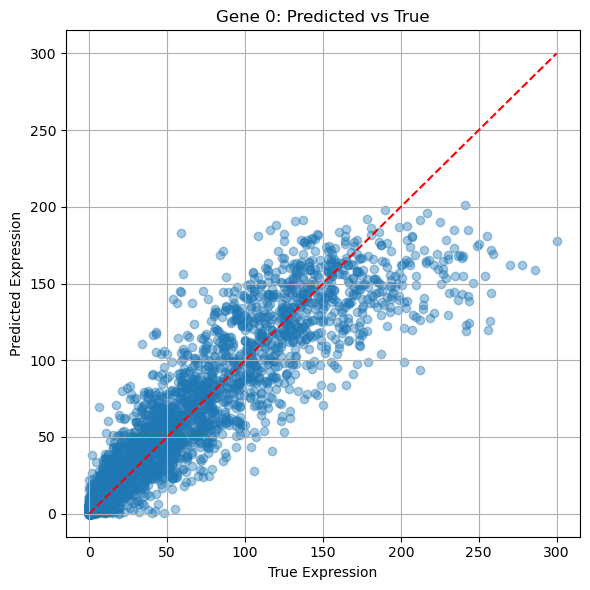

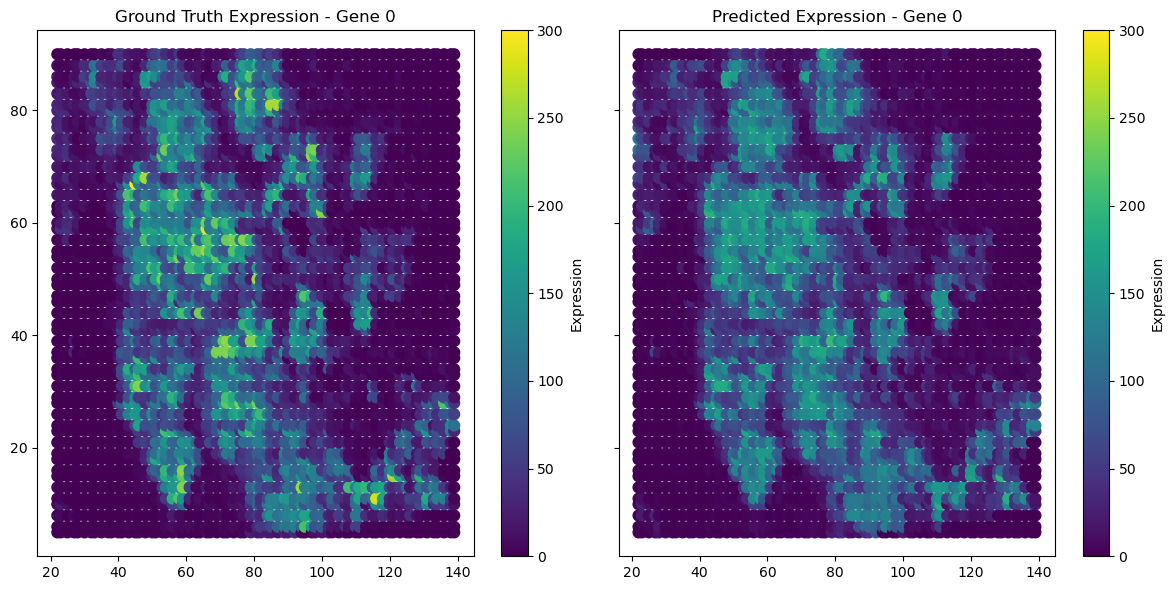

In [53]:
import numpy as np
import matplotlib.pyplot as plt

# -----------------------
# 1. Load predictions
# -----------------------
preds = np.load("predicted_gene_expression.npy")

# -----------------------
# 2. Load metadata
# -----------------------
metadata = np.load("virchow_embeds/patch_to_expr_NCBI783_metadata.npy", allow_pickle=True)

# -----------------------
# 3. Load ground truth expression
# -----------------------
expr = np.stack([m[3] for m in metadata])

# -----------------------
# 4. Extract spatial coordinates
# -----------------------
coords = np.array([m[2] for m in metadata])  # shape: (N_patches, 2)
x_coords = coords[:,0]
y_coords = coords[:,1]

# -----------------------
# 5. Choose gene to plot
# -----------------------
gene_idx = 0   # Change to whichever gene you want

true_values = expr[:, gene_idx]
pred_values = preds[:, gene_idx]

# -----------------------
# 6. Determine shared color scale
# -----------------------
vmin = min(true_values.min(), pred_values.min())
vmax = max(true_values.max(), pred_values.max())

# -----------------------
# 7. Plot side-by-side
# -----------------------
fig, axes = plt.subplots(1,2, figsize=(12,6), sharex=True, sharey=True)

# Ground truth
sc0 = axes[0].scatter(x_coords, y_coords, c=true_values, cmap="viridis", vmin=vmin, vmax=vmax, s=60)
axes[0].set_title(f"Ground Truth Expression - Gene {gene_idx}")
axes[0].invert_yaxis()
plt.colorbar(sc0, ax=axes[0], label="Expression")

# Prediction
sc1 = axes[1].scatter(x_coords, y_coords, c=pred_values, cmap="viridis", vmin=vmin, vmax=vmax, s=60)
axes[1].set_title(f"Predicted Expression - Gene {gene_idx}")
axes[1].invert_yaxis()
plt.colorbar(sc1, ax=axes[1], label="Expression")

plt.tight_layout()
plt.show()


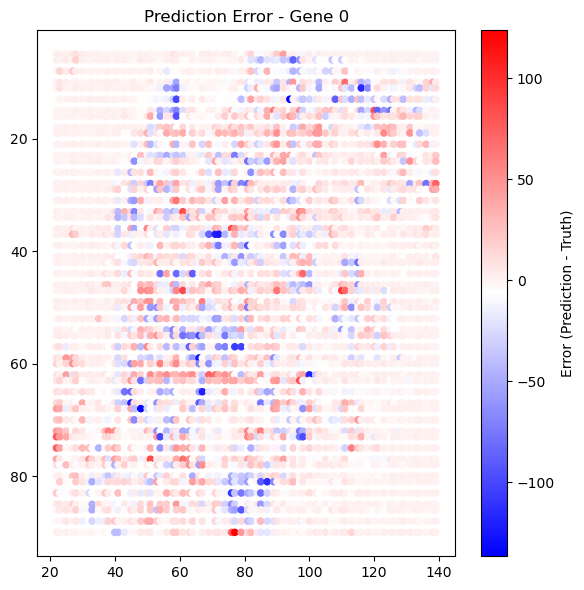

In [52]:
error = pred_values - true_values
plt.figure(figsize=(6,6))
plt.scatter(x_coords, y_coords, c=error, cmap="bwr", s=20)
plt.title(f"Prediction Error - Gene {gene_idx}")
plt.colorbar(label="Error (Prediction - Truth)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


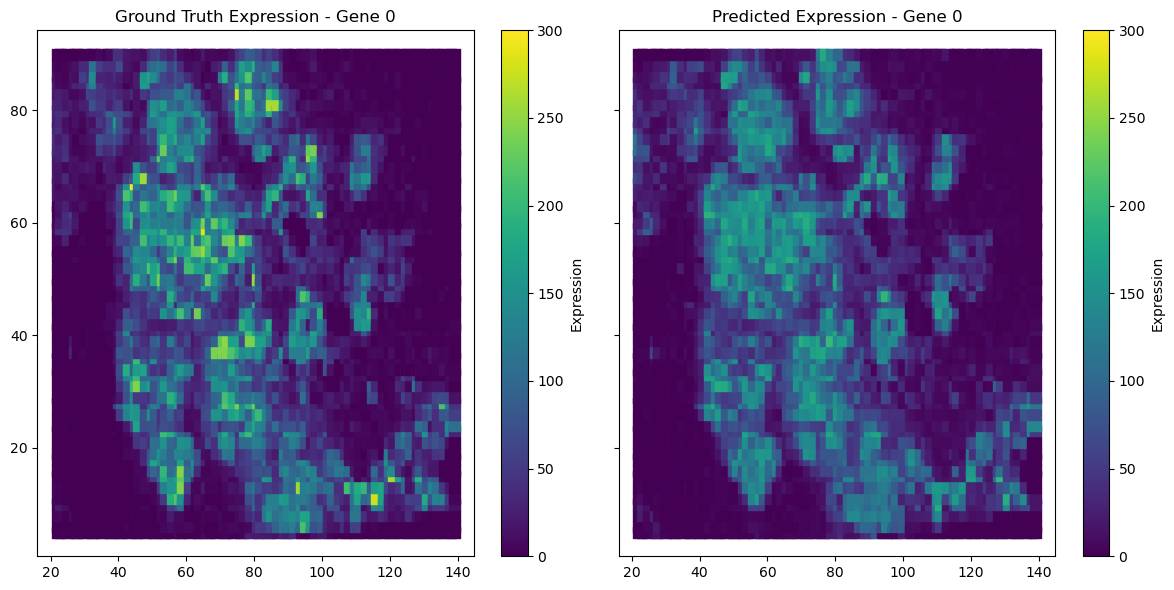

In [54]:
fig, axes = plt.subplots(1,2, figsize=(12,6), sharex=True, sharey=True)

# Ground truth
sc0 = axes[0].scatter(
    x_coords, y_coords,
    c=true_values,
    cmap="viridis",
    vmin=vmin,
    vmax=vmax,
    s=60,
    marker='s'  # 👈 square marker
)
axes[0].set_title(f"Ground Truth Expression - Gene {gene_idx}")
axes[0].invert_yaxis()
plt.colorbar(sc0, ax=axes[0], label="Expression")

# Prediction
sc1 = axes[1].scatter(
    x_coords, y_coords,
    c=pred_values,
    cmap="viridis",
    vmin=vmin,
    vmax=vmax,
    s=60,
    marker='s'  # 👈 square marker
)
axes[1].set_title(f"Predicted Expression - Gene {gene_idx}")
axes[1].invert_yaxis()
plt.colorbar(sc1, ax=axes[1], label="Expression")

plt.tight_layout()
plt.show()


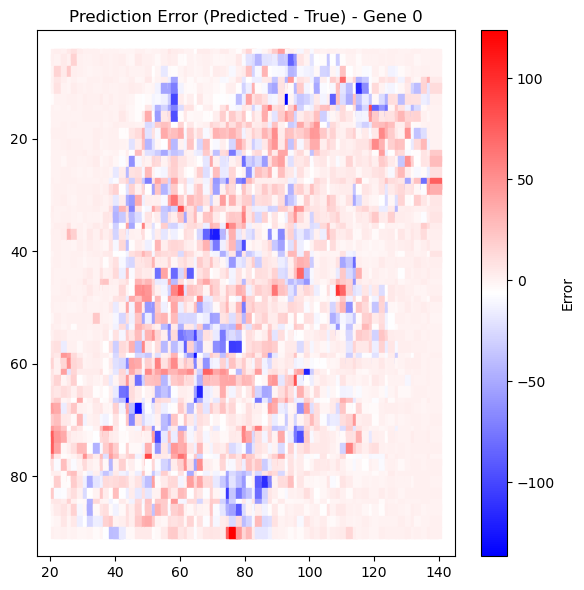

In [55]:
error = pred_values - true_values

plt.figure(figsize=(6,6))
sc = plt.scatter(
    x_coords, y_coords,
    c=error,
    cmap="bwr",  # blue-white-red diverging
    s=60,
    marker='s'
)
plt.title(f"Prediction Error (Predicted - True) - Gene {gene_idx}")
plt.colorbar(sc, label="Error")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


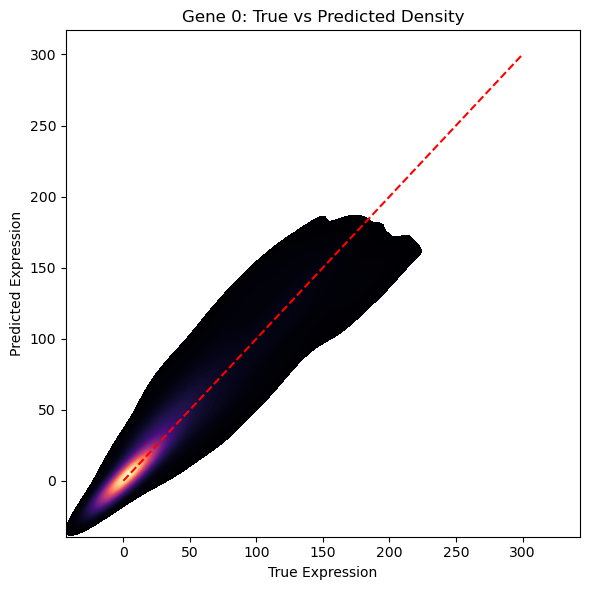

In [56]:
import seaborn as sns

plt.figure(figsize=(6,6))
sns.kdeplot(
    x=true_values,
    y=pred_values,
    fill=True,
    cmap="magma",
    thresh=0.05,
    levels=100
)
plt.plot(
    [true_values.min(), true_values.max()],
    [true_values.min(), true_values.max()],
    'r--'
)
plt.xlabel("True Expression")
plt.ylabel("Predicted Expression")
plt.title(f"Gene {gene_idx}: True vs Predicted Density")
plt.tight_layout()
plt.show()


/home/v-akthoutam/miniconda3/envs/squidp/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/v-akthoutam/miniconda3/envs/squidp/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


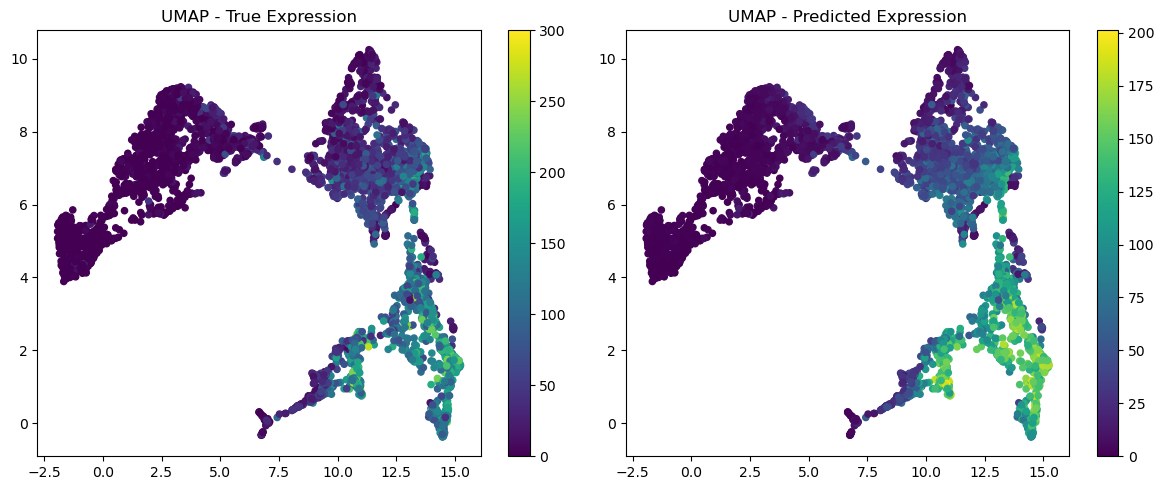

In [57]:
import umap

reducer = umap.UMAP(random_state=42)
embedding_2d = reducer.fit_transform(embeddings)

fig, axes = plt.subplots(1,2, figsize=(12,5))

# True
sc0 = axes[0].scatter(
    embedding_2d[:,0], embedding_2d[:,1],
    c=true_values,
    cmap="viridis",
    s=20
)
axes[0].set_title("UMAP - True Expression")
plt.colorbar(sc0, ax=axes[0])

# Predicted
sc1 = axes[1].scatter(
    embedding_2d[:,0], embedding_2d[:,1],
    c=pred_values,
    cmap="viridis",
    s=20
)
axes[1].set_title("UMAP - Predicted Expression")
plt.colorbar(sc1, ax=axes[1])

plt.tight_layout()
plt.show()


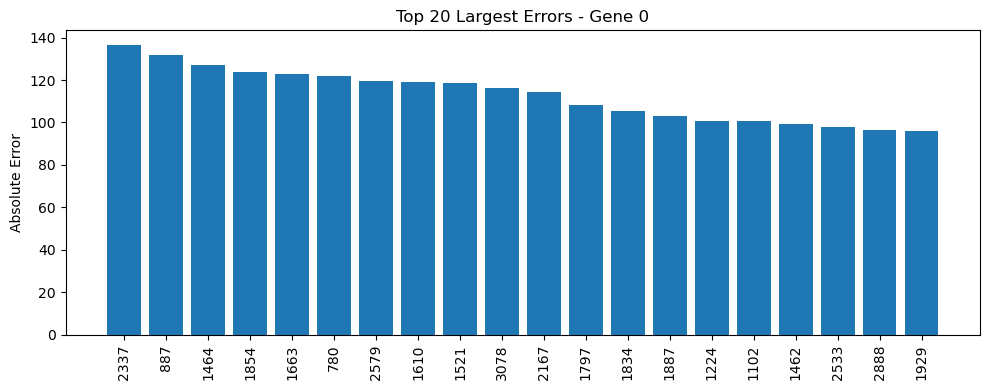

In [59]:
abs_error = np.abs(error)
sorted_idx = np.argsort(-abs_error)

top_n = 20

plt.figure(figsize=(10,4))
plt.bar(range(top_n), abs_error[sorted_idx[:top_n]])
plt.xticks(range(top_n), sorted_idx[:top_n], rotation=90)
plt.ylabel("Absolute Error")
plt.title(f"Top {top_n} Largest Errors - Gene {gene_idx}")
plt.tight_layout()
plt.show()


In [60]:
# Per-patch absolute error
abs_error = np.abs(pred_values - true_values)   # shape (N_patches,)

In [61]:
abs_error_all_genes = np.mean(np.abs(preds - expr), axis=1)

In [63]:
# Sorting index (descending error)
sorted_idx = np.argsort(-abs_error_all_genes)
print(sorted_idx)

[1981 1876 2179 ... 3855 3656 3851]


In [64]:
top_n = 10

print("Top patches with highest mean absolute error:")
for rank, idx in enumerate(sorted_idx[:top_n], 1):
    patch_info = metadata[idx]
    print(f"Rank {rank}: Patch #{idx} | File: {patch_info[0]} | Patch ID: {patch_info[2]} | Error: {abs_error_all_genes[idx]:.4f}")


Top patches with highest mean absolute error:
Rank 1: Patch #1981 | File: patch_to_expr_NCBI783.pkl | Patch ID: (82.0, 37.0) | Error: 15.2669
Rank 2: Patch #1876 | File: patch_to_expr_NCBI783.pkl | Patch ID: (79.0, 39.0) | Error: 14.0774
Rank 3: Patch #2179 | File: patch_to_expr_NCBI783.pkl | Patch ID: (89.0, 15.0) | Error: 13.8297
Rank 4: Patch #1521 | File: patch_to_expr_NCBI783.pkl | Patch ID: (67.0, 65.0) | Error: 13.6788
Rank 5: Patch #1607 | File: patch_to_expr_NCBI783.pkl | Patch ID: (71.0, 33.0) | Error: 13.2200
Rank 6: Patch #1289 | File: patch_to_expr_NCBI783.pkl | Patch ID: (61.0, 33.0) | Error: 12.9585
Rank 7: Patch #3830 | File: patch_to_expr_NCBI783.pkl | Patch ID: (139.0, 28.0) | Error: 12.9427
Rank 8: Patch #1611 | File: patch_to_expr_NCBI783.pkl | Patch ID: (71.0, 39.0) | Error: 12.7370
Rank 9: Patch #2036 | File: patch_to_expr_NCBI783.pkl | Patch ID: (84.0, 41.0) | Error: 12.5146
Rank 10: Patch #1664 | File: patch_to_expr_NCBI783.pkl | Patch ID: (72.0, 39.0) | Error: 

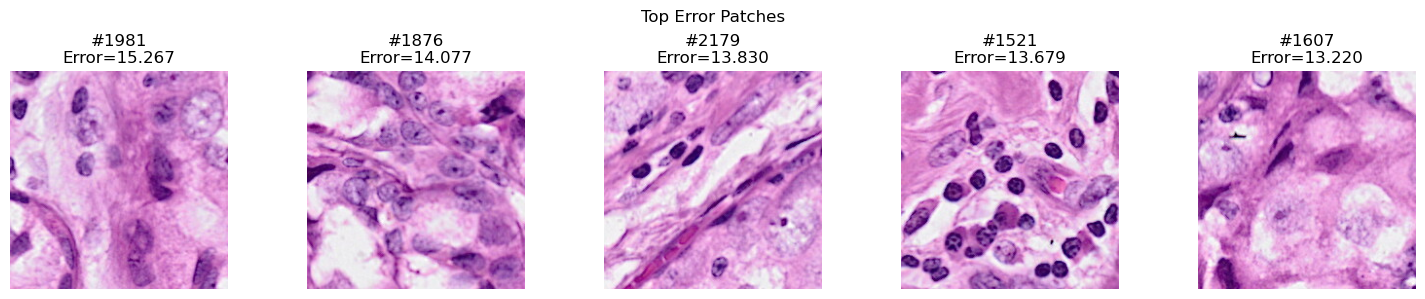

In [66]:
import pickle
import matplotlib.pyplot as plt

# Load your .pkl file (assuming all patches were in one .pkl file)
with open("preprocessed_HEST_data/patch_to_expr_NCBI783.pkl", "rb") as f:
    patches = pickle.load(f)

# Show the top N error patches
top_n = 5

fig, axes = plt.subplots(1, top_n, figsize=(3*top_n,3))

for i, idx in enumerate(sorted_idx[:top_n]):
    patch = patches[idx]
    axes[i].imshow(patch["pil"])
    axes[i].set_title(
        f"#{idx}\nError={abs_error_all_genes[idx]:.3f}"
    )
    axes[i].axis("off")

plt.suptitle("Top Error Patches")
plt.tight_layout()
plt.show()


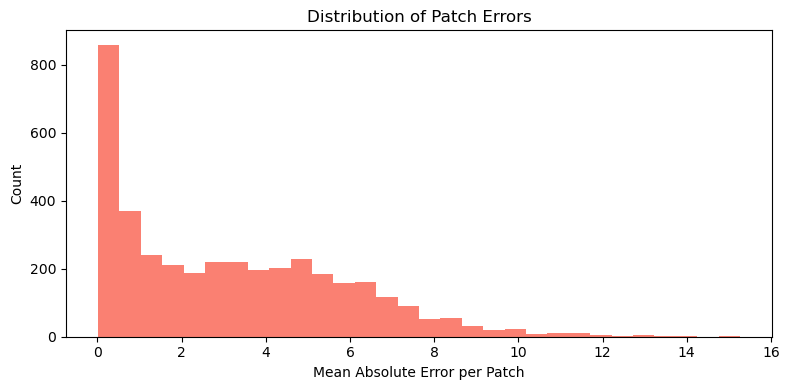

In [67]:
plt.figure(figsize=(8,4))
plt.hist(abs_error_all_genes, bins=30, color="salmon")
plt.xlabel("Mean Absolute Error per Patch")
plt.ylabel("Count")
plt.title("Distribution of Patch Errors")
plt.tight_layout()
plt.show()


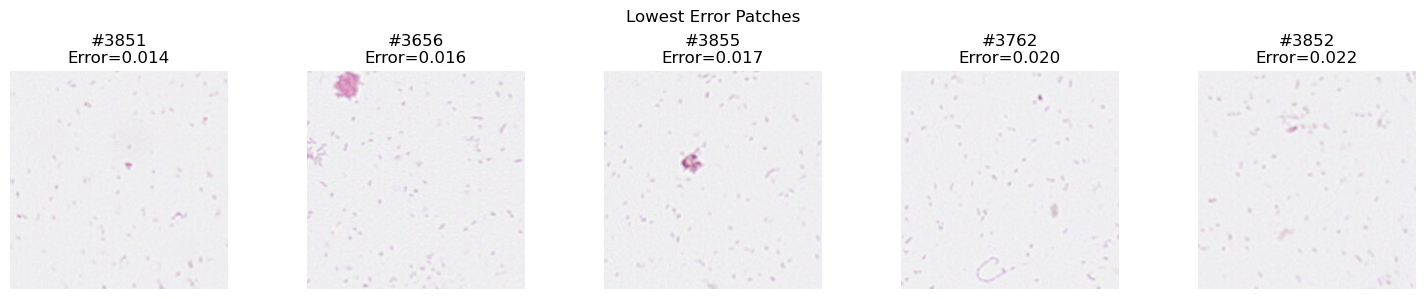

In [68]:
import pickle
import matplotlib.pyplot as plt
import numpy as np

# Load your .pkl file (assuming all patches were in one .pkl file)
with open("preprocessed_HEST_data/patch_to_expr_NCBI783.pkl", "rb") as f:
    patches = pickle.load(f)

# Sorting index (ascending error)
sorted_idx_low = np.argsort(abs_error_all_genes)

# Show the top N lowest-error patches
top_n = 5

fig, axes = plt.subplots(1, top_n, figsize=(3*top_n,3))

for i, idx in enumerate(sorted_idx_low[:top_n]):
    patch = patches[idx]
    axes[i].imshow(patch["pil"])
    axes[i].set_title(
        f"#{idx}\nError={abs_error_all_genes[idx]:.3f}"
    )
    axes[i].axis("off")

plt.suptitle("Lowest Error Patches")
plt.tight_layout()
plt.show()


In [ ]:
patch_std = np.std(expr, axis=1)

In [70]:
print("Mean expression std of low-error patches:", patch_std[sorted_idx_low[:10]].mean())
print("Mean expression std of high-error patches:", patch_std[sorted_idx[:10]].mean())


Mean expression std of low-error patches: 0.10143472273898183
Mean expression std of high-error patches: 75.49591433436356
